In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pyam
import scmdata

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
conn = pyam.iiasa.Connection()
conn.valid_connections

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.iiasa - INFO: You are connected as an anonymous user


['ariadne',
 'cdlinks',
 'cmin',
 'commit',
 'deeds',
 'engage',
 'hotspots',
 'integration-test',
 'nexus-basins',
 'ngfs',
 'ngfs_2',
 'openentrance',
 'paris_lttg',
 'ripples',
 'senses',
 'setnav',
 'iamc15',
 'iamc15-qa',
 'sandbox']

<IPython.core.display.Javascript object>

In [4]:
df = pyam.read_iiasa(
    "engage",
    variable=[
        "Emissions|*",
        "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED",
        "Diagnostics|MAGICC6|Harmonized Input|Emissions*",
    ],
    region="World",
)
df

pyam.iiasa - INFO: You are connected to the IXSE_ENGAGE scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ene.iiasa.ac.at/engage/#/about
pyam.iiasa - INFO: You are connected as an anonymous user


<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE V2.2, COFFEE 1.1, GEM-E3 V2021, IMAGE 3.0, ... WITCH 5.0 (10)
 * scenario : Baseline, EN_Baseline_1000, EN_Baseline_550, ... SmartUse (204)
Timeseries data coordinates:
   region   : World (1)
   variable : ... (126)
   unit     : GtC, Mt, Mt BC/yr, Mt CH4/yr, Mt CO/yr, ... °C rel. to 1850-1900 (35)
   year     : 1990, 1995, 2000, 2001, 2002, 2003, 2004, 2005, ... 2100 (103)
Meta indicators:
   version (object) 1, 2, 3, 4 (4)
   exclude (bool) False (1)

<IPython.core.display.Javascript object>

Use version 2 in line with Riahi et al. (see bottom of https://data.ene.iiasa.ac.at/engage/#/about which points to https://zenodo.org/record/5553976).

In [5]:
VERSION_TO_USE = 2

<IPython.core.display.Javascript object>

In [6]:
db = scmdata.ScmRun(
    df.filter(version=VERSION_TO_USE)
    .timeseries()
    .reset_index()
    .set_index(["model", "scenario"])
    .join(df.meta["version"])
)
db["model_scenario"] = db["model"] + "_" + db["scenario"]
db

<ScmRun (timeseries: 12253, timepoints: 103)>
Time:
	Start: 1990-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	              model                   model_scenario region            scenario                  unit                                                                         variable  version
	0      AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1000f  World  EN_INDCi2030_1000f  °C rel. to 1850-1900                      AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED        2
	1      AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1000f  World  EN_INDCi2030_1000f                    Mt                                Diagnostics|MAGICC6|Harmonized Input|Emissions|BC        2
	2      AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1000f  World  EN_INDCi2030_1000f                    kt                              Diagnostics|MAGICC6|Harmonized Input|Emissions|C2F6        2
	3      AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1000f  World  EN_INDCi2030_1000f                    kt              

<IPython.core.display.Javascript object>

In [7]:
use_db_harmonised = True

if not use_db_harmonised:
    ghg_vars = [
        "Emissions|CO2",
        "Emissions|CH4",
        "Emissions|N2O",
        "Emissions|HFC|*",
    ]

else:
    ghg_vars = [
        "*Harmonized Input*Emissions|CO2*",
        "*Harmonized Input*Emissions|CH4",
        "*Harmonized Input*Emissions|N2O",
        "*Harmonized Input*Emissions|HFC|*",
    ]

<IPython.core.display.Javascript object>

In [8]:
db["unit"] = db["unit"].apply(lambda x: x.replace("-", ""))
gwp = "AR6GWP100"

db_ghgs = (
    db.filter(variable=ghg_vars, year=range(2010, 2100 + 1)).timeseries().reset_index()
)

if use_db_harmonised:

    def fix_unit(row):
        unit = row.unit
        variable = row.variable
        if "HFC" in row.variable:
            unit = f"{unit}{row.variable.split('|')[-1]} / yr"
        else:
            unit = f"{unit} / yr"

        return unit.replace("-", "")

    db_ghgs["unit"] = db_ghgs[["variable", "unit"]].apply(fix_unit, axis=1)
    db_ghgs = scmdata.ScmRun(db_ghgs)

ghg_emms = (
    db_ghgs.resample("AS")
    .convert_unit("Gt CO2 / yr", context=gwp)
    .process_over(
        "variable",
        "sum",
        min_count=1,
        op_cols={"variable": "Emissions|GHG"},
        as_run=True,
    )
)
ghg_emms

<ScmRun (timeseries: 234, timepoints: 91)>
Time:
	Start: 2010-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	            model                   model_scenario region            scenario         unit unit_context       variable  version
	0    AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1000f  World  EN_INDCi2030_1000f  Gt CO2 / yr    AR6GWP100  Emissions|GHG        2
	1    AIM/CGE V2.2   AIM/CGE V2.2_EN_INDCi2030_1200  World   EN_INDCi2030_1200  Gt CO2 / yr    AR6GWP100  Emissions|GHG        2
	2    AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1200f  World  EN_INDCi2030_1200f  Gt CO2 / yr    AR6GWP100  Emissions|GHG        2
	3    AIM/CGE V2.2   AIM/CGE V2.2_EN_INDCi2030_1400  World   EN_INDCi2030_1400  Gt CO2 / yr    AR6GWP100  Emissions|GHG        2
	4    AIM/CGE V2.2  AIM/CGE V2.2_EN_INDCi2030_1400f  World  EN_INDCi2030_1400f  Gt CO2 / yr    AR6GWP100  Emissions|GHG        2
	5    AIM/CGE V2.2   AIM/CGE V2.2_EN_INDCi2030_1600  World   EN_INDCi2030_1600  Gt CO2 / yr    AR6GWP100  Emissions|G

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Gt CO2 / yr'>

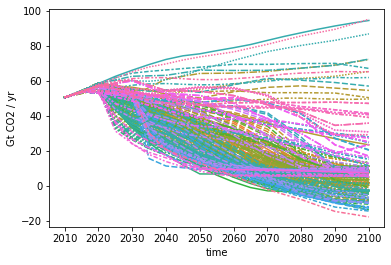

<IPython.core.display.Javascript object>

In [9]:
ghg_emms.lineplot(style="model", legend=False)

In [10]:
scenario_a_2050_ghg_emms = 27
scenario_a_2050_ghg_year = 2050
scenario_a_2050_ghg_emms_unit = "GtCO2 / yr"
keep_closest_n = 25

<IPython.core.display.Javascript object>

In [11]:
close_engage_scenarios = (
    (
        ghg_emms.filter(year=scenario_a_2050_ghg_year)
        .convert_unit(scenario_a_2050_ghg_emms_unit, context=gwp)
        .timeseries(time_axis="year")
        - scenario_a_2050_ghg_emms
    )
    .abs()
    .sort_values(by=scenario_a_2050_ghg_year, ascending=True)
    .iloc[:keep_closest_n, :]
)
close_engage_scenarios = close_engage_scenarios.index.get_level_values(
    "model_scenario"
).tolist()
close_engage_scenarios

['IMAGE 3.0_EN_NPi2020_1400',
 'COFFEE 1.1_EN_NPi2020_1000',
 'WITCH 5.0_EN_INDCi2030_1600',
 'WITCH 5.0_EN_INDCi2030_1600f',
 'COFFEE 1.1_EN_INDCi2030_600f',
 'COFFEE 1.1_EN_NPi2020_600f',
 'AIM/CGE V2.2_EN_NPi2020_900f',
 'TIAM-ECN 1.1_EN_NPi2020_1000f',
 'POLES-JRC ENGAGE_EN_INDCi2030_1400',
 'TIAM-ECN 1.1_EN_INDCi2030_1000f',
 'WITCH 5.0_EN_NPi2020_1400f',
 'POLES-JRC ENGAGE_EN_NPi2020_1200f',
 'POLES-JRC ENGAGE_EN_INDCi2030_1400f',
 'WITCH 5.0_EN_NPi2020_1400',
 'WITCH 5.0_EN_NPi2020_1600',
 'IMAGE 3.0_EN_NPi2020_1400f',
 'AIM/CGE V2.2_EN_INDCi2030_1200',
 'AIM/CGE V2.2_EN_NPi2020_800f',
 'WITCH 5.0_EN_NPi2020_1600f',
 'IMAGE 3.0_EN_INDCi2030_1400f',
 'POLES-JRC ENGAGE_EN_NPi2020_1400',
 'IMAGE 3.0_EN_INDCi2030_1400',
 'COFFEE 1.1_EN_INDCi2030_1000',
 'AIM/CGE V2.2_EN_NPi2020_1200',
 'WITCH 5.0_EN_INDCi2030_1400f']

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Gt CO2 / yr'>

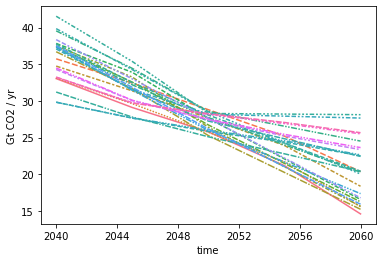

<IPython.core.display.Javascript object>

In [12]:
ghg_emms.filter(year=range(2040, 2060 + 1), model_scenario=close_engage_scenarios).lineplot(style="model_scenario", legend=False)


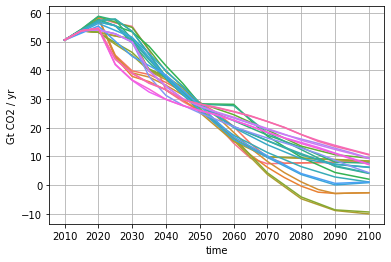

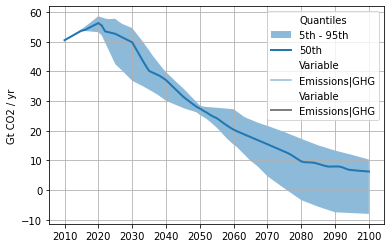

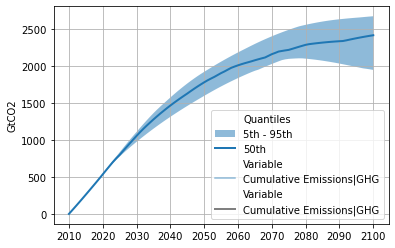

<IPython.core.display.Javascript object>

In [13]:
tmp = ghg_emms.filter(model_scenario=close_engage_scenarios)

ax = tmp.lineplot(hue="model_scenario", legend=False)
ax.grid()
plt.show()

tmp["model"] = "model"
tmp["scenario"] = "scenario"
ax, _ = tmp.plumeplot(
    quantile_over=("model_scenario",), hue_var="variable", hue_label="Variable"
)
ax.grid()
plt.show()

ax, _ = (
    tmp.integrate()
    .convert_unit("GtCO2", context=gwp)
    .plumeplot(
        quantile_over=("model_scenario",), hue_var="variable", hue_label="Variable"
    )
)
ax.grid()
plt.show()

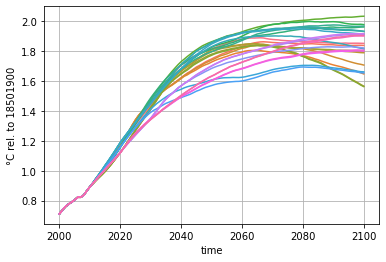

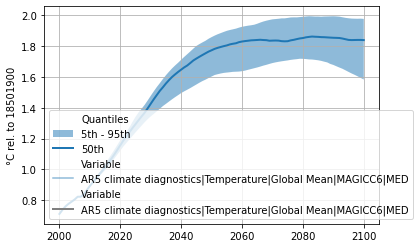

<IPython.core.display.Javascript object>

In [14]:
tmp = db.filter(
    model_scenario=close_engage_scenarios,
    variable="AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED",
)

ax = tmp.lineplot(hue="model_scenario", legend=False)
ax.grid()
plt.show()

tmp["model"] = "model"
tmp["scenario"] = "scenario"
ax, _ = tmp.plumeplot(
    quantile_over=("model_scenario",), hue_var="variable", hue_label="Variable"
)
ax.grid()
plt.show()

In [15]:
db.get_unique_meta("variable")

['AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|BC',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|C2F6',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|C6F14',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|CH4',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|CO',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|CO2|AFOLU',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|CO2|Energy and Industrial Processes',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC125',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC134a',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC143a',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC227ea',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC23',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC245ca',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC32',
 'Diagnostics|MAGICC6|Harmonized Input|Emissions|HFC|HFC43-10',
 'Diagnost

<IPython.core.display.Javascript object>